# Project1 - Python
Name: Claudia Vivas

# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

## Question 1

## Data analysis

We consider the same subsample of the U.S. Current Population Survey (2015) as in the previous lab. Let us load the data set.

In [3]:
import pandas as pd
import numpy as np
import pyreadr 
import math

In [4]:
rdata_read = pyreadr.read_r("../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data_1 = rdata_read[ 'data' ]

data.shape

NameError: name 'data' is not defined

In [11]:
data_1 = rdata_read[ 'data' ]
data = data_1[(data_1['scl'] == 1) | (data_1['clg'] == 1)]
data.head()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
rownames,,,,,,,,,,,,,,,,,,,,
10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
30,11.730769,2.462215,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.01,0.001,0.0001,1650,5,7460,14
71,19.230769,2.956512,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.16,0.064,0.0256,3255,10,8190,18


To start our (causal) analysis, we compare the sample means given gender:

In [12]:
Z = data[ ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] ]

data_female = data[data[ 'sex' ] == 1 ]
Z_female = data_female[ ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] ]

data_male = data[ data[ 'sex' ] == 0 ]
Z_male = data_male[ [ "lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1" ] ]


table = np.zeros( (12, 3) )
table[:, 0] = Z.mean().values
table[:, 1] = Z_male.mean().values
table[:, 2] = Z_female.mean().values
table_pandas = pd.DataFrame( table, columns = [ 'All', 'Men', 'Women'])
table_pandas.index = ["Log Wage","Sex","Less then High School","High School Graduate","Some College","Gollage Graduate","Advanced Degree", "Northeast","Midwest","South","West","Experience"]
table_html = table_pandas.to_html()

table_pandas

,All,Men,Women
Log Wage,3.000022,3.038412,2.956904
Sex,0.470991,0.000000,1.000000
Less then High School,0.000000,0.000000,0.000000
High School Graduate,0.000000,0.000000,0.000000
Some College,0.466754,0.481824,0.449827
Gollage Graduate,0.533246,0.518176,0.550173
Advanced Degree,0.000000,0.000000,0.000000
Northeast,0.226532,0.219347,0.234602
Midwest,0.265971,0.261245,0.271280
South,0.285854,0.290819,0.280277


In particular, the table above shows that the difference in average *logwage* between men and women is equal to $0,038$

In [13]:
data_female['lwage'].mean() - data_male['lwage'].mean()

-0.08150855508735999

Thus, the unconditional gender wage gap is about $8.15$\% for the group of never married workers (women get paid less on average in our sample). We also observe that never married working women are relatively more educated than working men and have lower working experience.

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

\begin{align}
\log(Y) &=\beta D + \epsilon.
\end{align}

We verify this by running an ols regression in R.

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [15]:
nocontrol_model = smf.ols( formula = 'lwage ~ sex', data = data )
nocontrol_est = nocontrol_model.fit().summary2().tables[1]['Coef.']['sex']
nocontrol_model.fit().cov_HC0

array([[ 0.00019006, -0.00019006],
       [-0.00019006,  0.00038336]])

In [16]:
nocontrol_model = smf.ols( formula = 'lwage ~ sex', data = data )
nocontrol_est = nocontrol_model.fit().summary2().tables[1]['Coef.']['sex']
HCV_coefs = nocontrol_model.fit().cov_HC0
nocontrol_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# print unconditional effect of gender and the corresponding standard error
print( f'The estimated gender coefficient is {nocontrol_est} and the corresponding robust standard error is {nocontrol_se}' )

The estimated gender coefficient is -0.08150855508736052 and the corresponding robust standard error is 0.019579647767772428


Note that the standard error is computed with the *R* package *sandwich* to be robust to heteroskedasticity. 


Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

Let us run the ols regression with controls.

## Ols regression with controls

In [17]:
flex = 'lwage ~ sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'

# The smf api replicates R script when it transform data
control_model = smf.ols( formula = flex, data = data )
control_est = control_model.fit().summary2().tables[1]['Coef.']['sex']

print(control_model.fit().summary2().tables[1])
print( f"Coefficient for OLS with controls {control_est}" )

HCV_coefs = control_model.fit().cov_HC0
control_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

               Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
Intercept   2.073357  0.214419  9.669647  8.761691e-22  1.652924  2.493790
occ2[T.10]  0.091982  0.243220  0.378184  7.053225e-01 -0.384925  0.568888
occ2[T.11] -0.499418  0.436858 -1.143202  2.530511e-01 -1.356010  0.357175
occ2[T.12]  0.190101  0.341142  0.557249  5.774012e-01 -0.478810  0.859012
occ2[T.13] -0.194529  0.271881 -0.715492  4.743637e-01 -0.727633  0.338575
...              ...       ...       ...           ...       ...       ...
exp4:scl    0.021375  0.022071  0.968465  3.328946e-01 -0.021902  0.064653
exp4:clg    0.007909  0.021929  0.360650  7.183881e-01 -0.035090  0.050908
exp4:mw     0.014287  0.025814  0.553477  5.799802e-01 -0.036328  0.064902
exp4:so    -0.003759  0.022547 -0.166725  8.675981e-01 -0.047968  0.040450
exp4:we     0.028286  0.023812  1.187890  2.349761e-01 -0.018405  0.074978

[246 rows x 6 columns]
Coefficient for OLS with controls -0.05306234035775666


The estimated regression coefficient $\beta_1\approx-0.0531$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $4$\% for women increases to about $7$\% after controlling for worker characteristics.  


Next, we are using the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

## Partialling-Out using ols

In [18]:
# models
# model for Y
flex_y = 'lwage ~  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'
# model for D
flex_d = 'sex ~ (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)' 

# partialling-out the linear effect of W from Y
t_Y = smf.ols( formula = flex_y , data = data ).fit().resid

# partialling-out the linear effect of W from D
t_D = smf.ols( formula = flex_d , data = data ).fit().resid

data_res = pd.DataFrame( np.vstack(( t_Y.values , t_D.values )).T , columns = [ 't_Y', 't_D' ] )
# regression of Y on D after partialling-out the effect of W
partial_fit =  smf.ols( formula = 't_Y ~ t_D' , data = data_res ).fit()
partial_est = partial_fit.summary2().tables[1]['Coef.']['t_D']

print("Coefficient for D via partialling-out", partial_est)

# standard error
HCV_coefs = partial_fit.cov_HC0
partial_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# confidence interval
partial_fit.conf_int( alpha=0.05 ).iloc[1, :]

Coefficient for D via partialling-out -0.0530623403577537


0   -0.089571
1   -0.016554
Name: t_D, dtype: float64

Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

## Question 2

In [19]:
datas = data[data['scl'] == 1]
datac = data[data['clg'] == 1]

In [20]:
# scl
scl = datas[['lwage','exp1']].groupby(['exp1']).mean().reset_index()
scl['mean'] = 0
scl

,exp1,lwage,mean
0,3.0,2.693883,0
1,3.5,2.729320,0
2,4.0,2.696418,0
3,4.5,2.611629,0
4,5.0,2.727195,0
...,...,...,...
75,40.5,2.889598,0
76,41.0,3.011219,0
77,41.5,3.097123,0
78,42.0,2.668829,0


In [21]:
scl.shape

(80, 3)

In [28]:
# clg
clg = datac[['lwage','exp1']].groupby(['exp1']).mean().reset_index()
clg['mean'] = 0
clg

,exp1,lwage,mean
0,1.0,3.031143,0
1,2.0,3.019492,0
2,3.0,3.061553,0
3,4.0,3.070771,0
4,5.0,3.030900,0
5,6.0,3.182292,0
6,7.0,3.107772,0
7,8.0,3.142271,0
8,9.0,3.038090,0
9,10.0,3.139449,0


In [22]:
clg.shape

(40, 3)

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
for i in range(0,80):
    w = datas[datas['exp1'] <= scl['exp1'][i]]
    scl['mean'][i] = w['lwage'].mean()
print(scl['mean'])

0     2
1     2
2     2
3     2
4     2
     ..
75    2
76    2
77    2
78    2
79    2
Name: mean, Length: 80, dtype: int64


In [29]:
for i in range(0,40):
    w = datac[datac['exp1'] <= clg['exp1'][i]]
    clg['mean'][i] = w['lwage'].mean()
print(clg['mean'])

0     3
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
19    3
20    3
21    3
22    3
23    3
24    3
25    3
26    3
27    3
28    3
29    3
30    3
31    3
32    3
33    3
34    3
35    3
36    3
37    3
38    3
39    3
Name: mean, dtype: int64


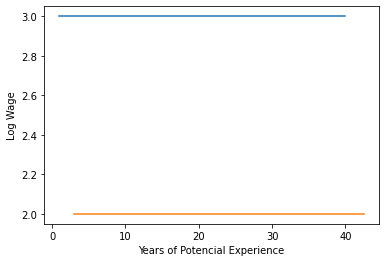

In [30]:
#Plot
import matplotlib.pyplot as plt

x = clg["exp1"]
x1 = scl['exp1']
y = clg["mean"]
y1 = scl['mean']

plt.plot(x,y, label="College")
plt.plot(x1,y1,label="High school")
plt.xlabel("Years of Potencial Experience")
plt.ylabel("Log Wage")
plt.show()

## Question 3

# Frisch-Waugh-Lovell

In the linear least squares regression of vector y on two sets of variables, $X_1$ and $X_2$, the subvector $b_2$ is the set of coefficients obtained when the residuals from a regression of y on $X_1$ alone are regressed on the set of residuals obtained when each
column of $X_2$ is regressed on $X_1$.

Suppose that the regression involves two sets of variables, $X_1$ and $X_2$. Thus,

$$y = X\beta + \varepsilon = X_1\beta_1 + X_2\beta_2 + \varepsilon $$

We want to know $\beta_2$. Nevertheless, the two sets of variables $X_1$ and $X_2$ are not orthogonal, then Frisch-Waugh-Lovell theorem is needed. 
What is the algebraic solution for $\beta_2$? A solution can be obtained by using the partitioned inverse matrix.

$$
\left(\begin{array}{cc} 
X_1'X_1 & X_1'X_2\\
X_2'X_1 & X_2'X_2
\end{array}\right)
\left(\begin{array}{cc} 
b_1 \\ 
b_2 
\end{array}\right)
=
\left(\begin{array}{cc} 
X_1'y \\ 
X_2'y
\end{array}\right)
$$ 

First, we solve $\beta_1$, where $\beta_1$ is the set of coefficientes of $y$ on $X_1$.
$$ X_1'X_1b_1 + X_1'X_2b_2=X_1'y $$
$$b_1 = (X_1'X_1)^-1X'_1y - (X'_1X_1)^-1X'_1X_2b_2 $$

Then, use the second equation of the partitioned inverse matrix.
$$ X_2'X_1b_1 + X_2'X_2b_2=X_2'y $$

Now, insert the result for $\beta_1$. This produces:
$$X_2'X_1(X_1'X_1)^-1X'_1y-X'_2X_1(X'_1X_1)^-1X'_1X_2b_2+X'_2X_2b_2=X'_2y$$
$$X_2'(I-X_1(X_1'X_1)^-1y=X_2'(I-X_1(X_1'X_1)^-1)X_2b_2$$
$$b_2 =[X_2'(I-X_1(X_1'X_1)^-1)X_2]^-1[X_2'(I-X_1(X_1'X_1)^-1)y]$$

The $M_1$ matrix is the residual maker:
$$M_1=I-X_1(X_1'X_1)^-1$$

Insert $M_1$ in the equiation below:
$$b_2 =[X_2'M_1X_2]^-1[X_2'M_1y]$$

Thus, $M_1X_2$ is a matrix of residuals in the regression of $X_2$ on $X_1$, and $M_1y$  is a matrix of residuals in the regression of $y$ in $X_1$. By exploiting the fact that $M_1$ is symmetric and idempotent, we can rewrite the equation as:

$X_2*=M_1X_2$ and $y*=M_1y$ 
$$b_2=(X'_2*X_2*)^-1X'_2*y*$$
​ 
This process is commonly called partialing out or netting out the effect of $X_1$.

On the other hand, If we follow the algorithm seen in class we can reach the same result. In essence, the demonstration above follows the same algorithm, however, the following demonstration may be easier to understand.

Suppose that the regression involves two sets of variables, $X_1$ and $X_2$. Thus,

$$y = X\beta + u = X_1\beta_1 + X_2\beta_2 + u $$

To find $\beta_1$ follow the next algorithm:

1. Regress $y$ on $X_1$, obtain residual $e_1$
2. Regress $X_2$ on $X_1$, obtain residual $e_2$
3. Regress $e_1$ on $e_2$, obtain OLS estimates $b_1$

$$y=X_2\beta_1+u_1$$    
$$\beta_1=(X'_2X_2)^-1(X'_2y)$$
$$X_1=X_2\beta_2+u_2$$
$$\beta_2=(X'_2X_2)^-1(X'_2X_1)$$

$$y-X_2\beta_1=u_1$$

Insert $D_1$:
$$y-[X_2(X'_2X_2)^-1(X'_2y)]=e_1$$
$$[I-(X'_2X_2)^-1(X'_2)]y= e_1$$
$$M_2y=e_1$$

Remember the $M_2=I-X_2(X_2'X_2)^-1$ matrix is the residual maker. Then, the estimated residuals are:
$$e_1=M_2y$$
$$e_2=M_2X_1$$

Now, we regress $e_1$ on $e_2$:

$$e_1=e_2\beta_1+\varepsilon$$
$$b_1=(e_2'e_2)^-1(e_2'e_1)$$

Insert estimated residual $e_1$ and $e_2$:
$$b_1=(M_2X_1)'(M_2X_1)^-1[(M_2X_1)'(M_2X_1)]$$
$$b_1=(X_1'M_2'M_2X_1)^-1(X_1'M_2'M_2y) $$

Regarding, $M_2$ is symmetric and idempotent. 
$X_1*=M_2X_1$ and $y*=M_2y$ 
$$b_1=(X'_1*X_1*)^-1X'_1*y*$$

This theorem shows the pure effect of the exogenous variables that are of interest, this result is the same that would have been obtained if the model had been regressed with all the variables.